<a href="https://colab.research.google.com/github/SushmitaM1/RNA_Analysis_python/blob/main/RNA_expression_analysis_Python3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will perform gene expression analysis with data from CD34+ cells from MPN (myeloproliferative neoplasms) patients as presented in the study ([Link_to_study](https://link.springer.com/article/10.1007/s00277-021-04615-8)). For this, we will consider previously normalized gene expression data and will perform down-stream analysis such as principal component analysis, clustering, identification of differentially expressed genes and gene ontology analysis. We have following sections in this notebook:

1. Analysing RNA expression data: Perform a diemnsion reduction using different embedding algorithms to check the variability presented by our dataset.

2. Differential gene expression: Perform a differential gene expression analysis to identify genes have incresase or decrease in expression in MPN samples.

3. Complex differential gene expression: Perform a differential gene expression contrasting distinct MPN entities.


**1. Analysing RNA expression samples and its organisation**

**1.1. Importing the librabries**

- Data science and maths: scipy numpy pandas sklearn
-Visualisation: matplotlib seaborn
-RNA data organisation and DE analysis: anndata diffxpy
-Gene enrichment analysis: gprofiler

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf-nightly
!pip install tfp-nightly 

In [2]:
! git clone https://github.com/theislab/batchglm.git

Cloning into 'batchglm'...
remote: Enumerating objects: 11661, done.
remote: Counting objects: 100% (1957/1957), done.
remote: Compressing objects: 100% (695/695), done.
remote: Total 11661 (delta 1236), reused 1925 (delta 1218), pack-reused 9704
Receiving objects: 100% (11661/11661), 2.64 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (8219/8219), done.


In [4]:
! pip install /content/batchglm

Processing ./batchglm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for batchglm: filename=batchglm-0.7.4+5.g31b905b-py3-none-any.whl size=141819 sha256=1fc4718fd5e8370f66c1251c4432a2f68240b7674e03894c8163fd895b68ade5
  Stored in directory: /tmp/pip-ephem-wheel-cache-296lkq4s/wheels/57/fe/39/538ceb8afe7afd22b41a3cb9e4d62d176075dca70cd58d4345
Successfully built batchglm
  Attempting uninstall: batchglm
    Found existing installation: batchglm 0.7.4+5.g31b905b
    Uninstalling batchglm-0.7.4+5.g31b905b:
      Successfully uninstalled batchglm-0.7.4+5.g31b905b


In [5]:
! git clone https://github.com/theislab/diffxpy.git

Cloning into 'diffxpy'...
remote: Enumerating objects: 2873, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2873 (delta 187), reused 261 (delta 184), pack-reused 2608
Receiving objects: 100% (2873/2873), 1.68 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (2005/2005), done.


In [6]:
! pip install /content/diffxpy

Processing ./diffxpy
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for diffxpy: filename=diffxpy-0.7.4+21.g12f1286-py3-none-any.whl size=87218 sha256=3e9fe7c97d483055e4f6b9566884029e58e343d2478ee81763b98bdcceddcf23
  Stored in directory: /tmp/pip-ephem-wheel-cache-q62vn9_q/wheels/32/48/30/cbc2608c3c5686500196b56d44d4f2953c4b5688d0fd29578d
Successfully built diffxpy


In [7]:
! pip install gprofiler-official

In [8]:
from scipy.cluster.hierarchy import average, fcluster   #
from scipy.spatial.distance import pdist, squareform
from scipy import cluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import diffxpy.api as de
import anndata
from gprofiler import GProfiler
sns.set_style("whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1.2 Data aquisition and Pre-processing

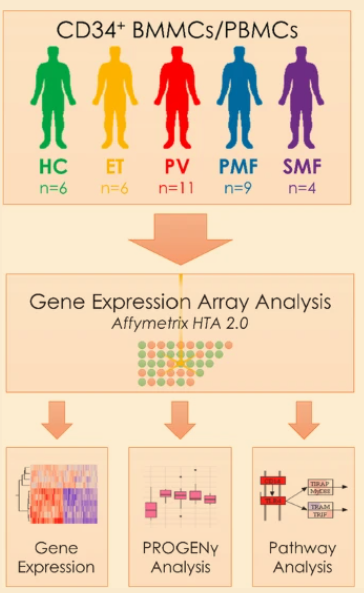

First, I will load a pre-processed gene expression table from 36 patient/donor samples (gene_exp.csv). Additionaly, I will load a metadata table containing patient clinical information including disease entity (HC, ET, PV, PMF and SMF); age, sex, type of treatment and so on. Number of samples per disease entity is shown in image above.

In [9]:
data = anndata.read_h5ad("/content/drive/MyDrive/Bioinfo costalab/RNA_Expression_Analysis_in_Python/data/cd34.h5ad")

Now, check the distribution of gene expression in each collected sample.

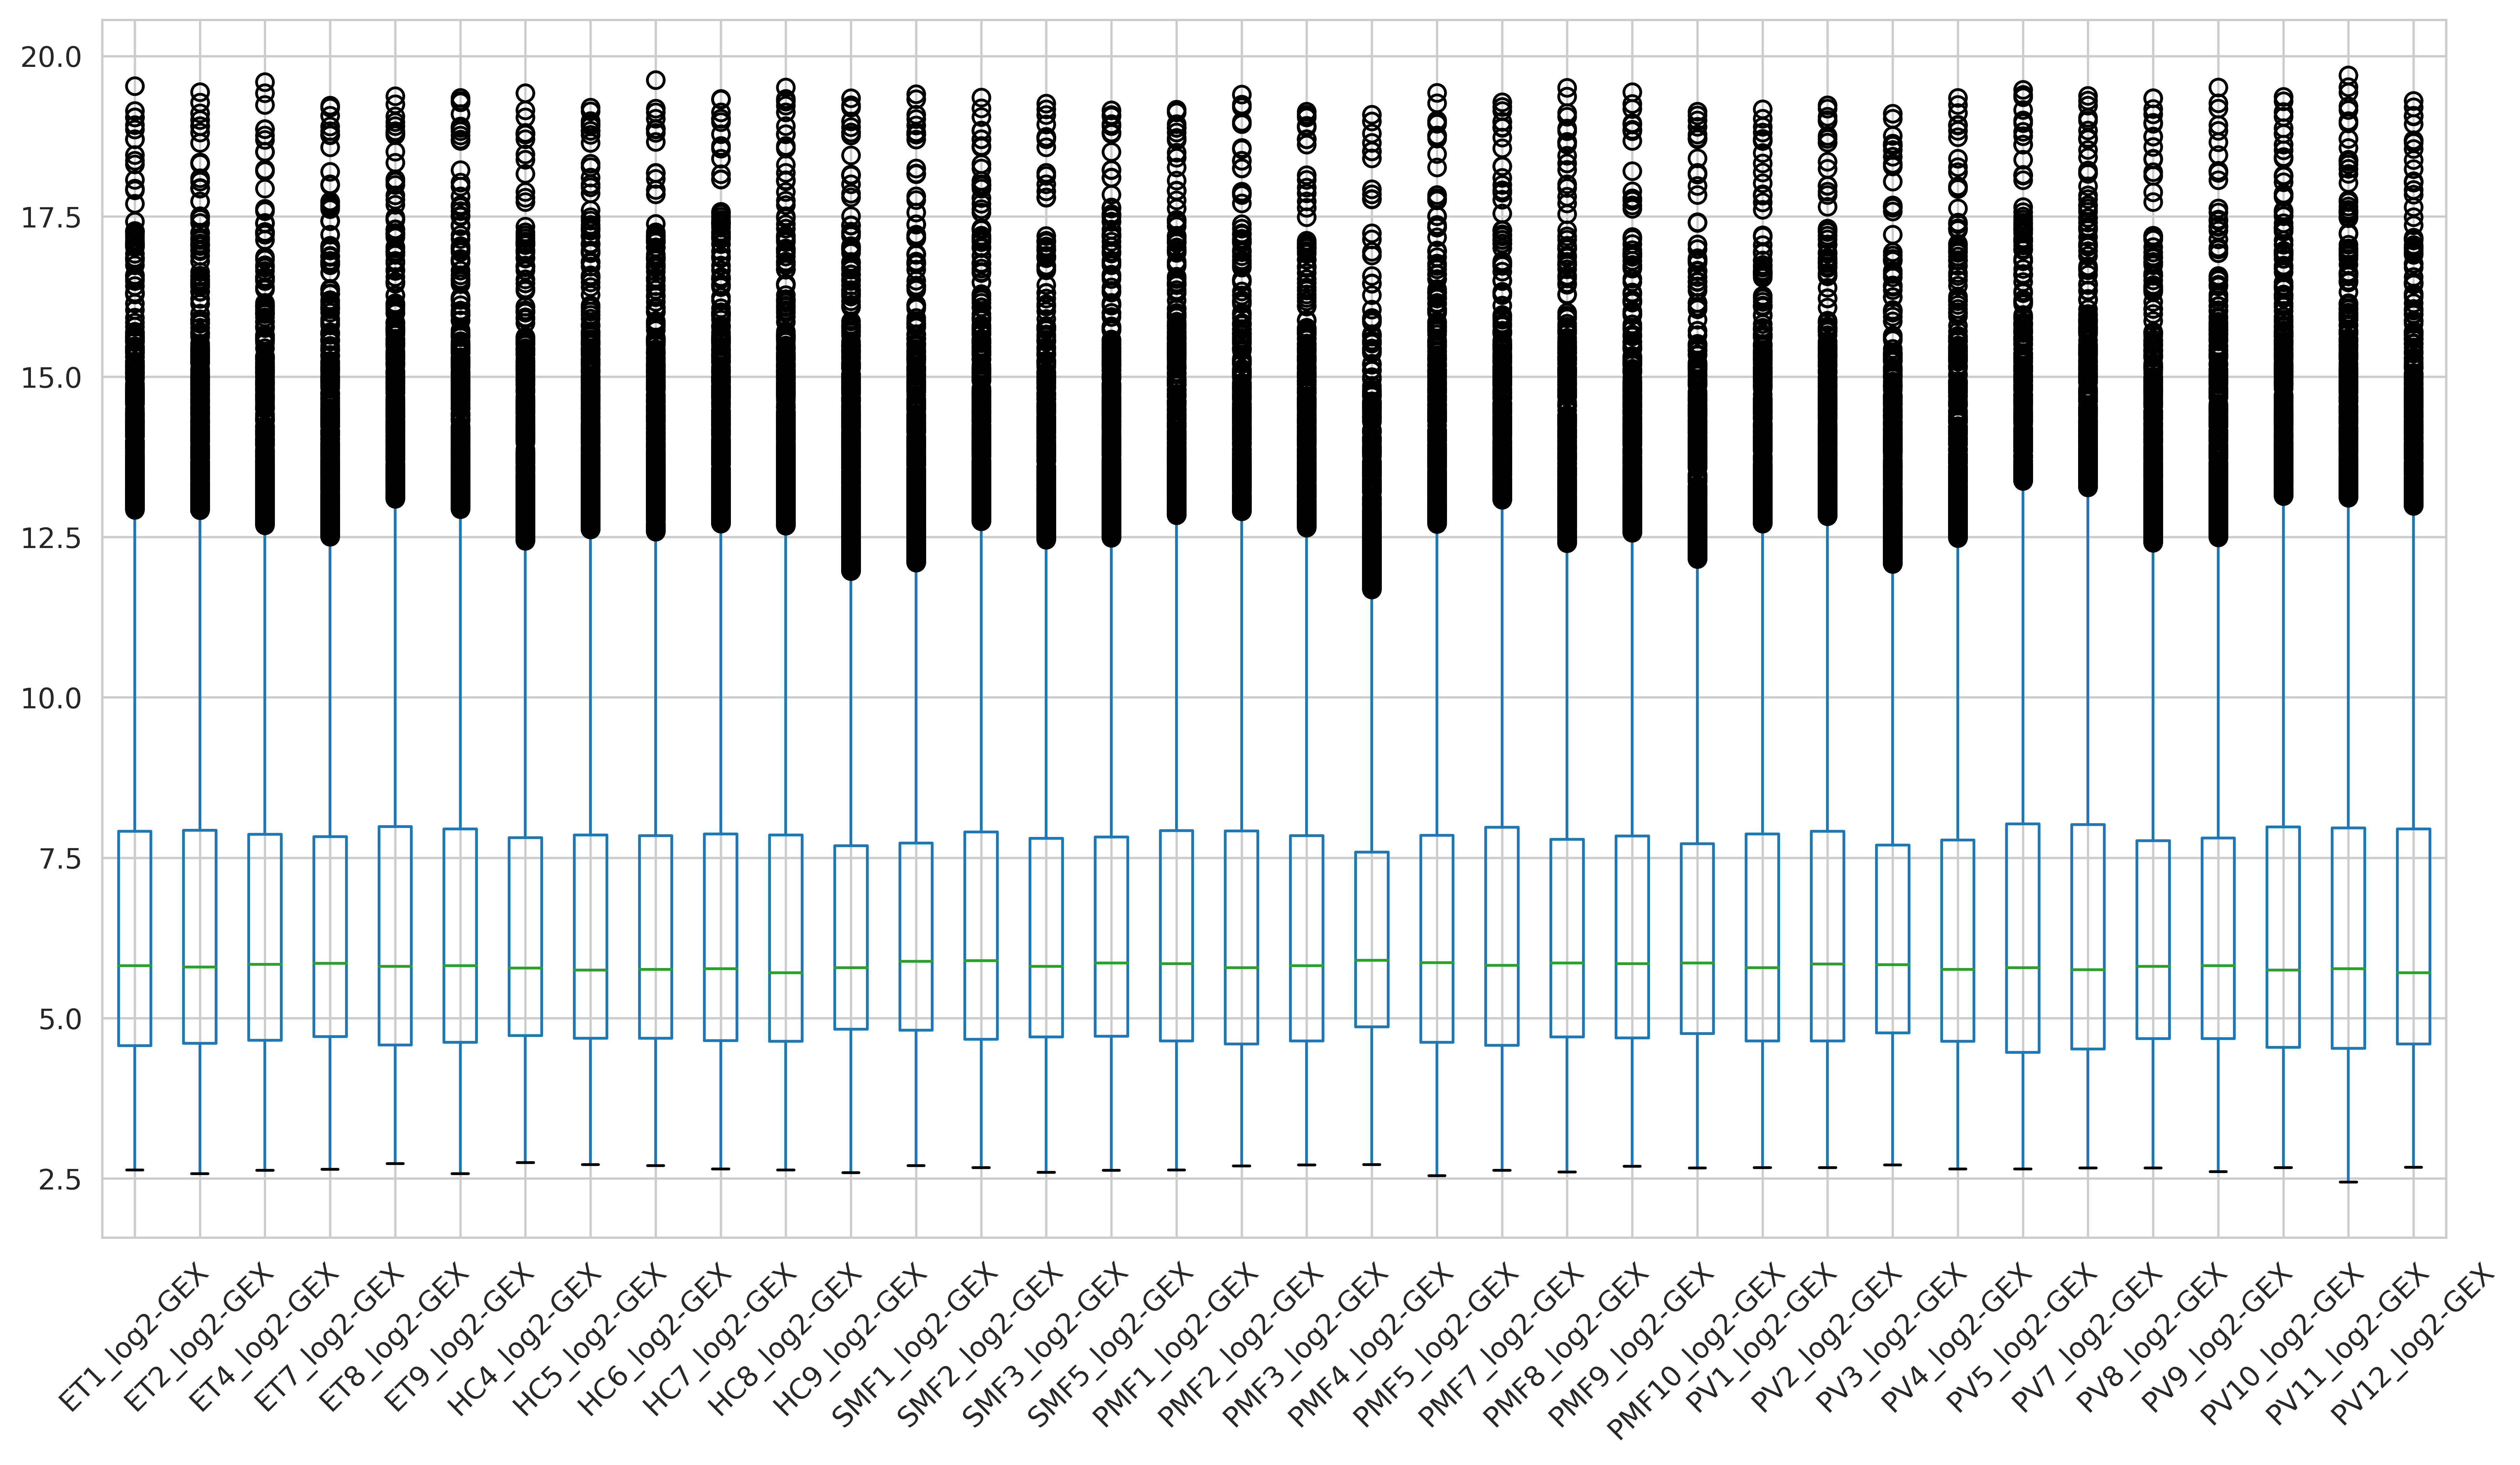

In [10]:
plt.figure(figsize=(15,8), dpi=600)
data.to_df().T.boxplot()
l=plt.xticks(rotation=45)

Sort the clinical data to follow the same organisation of samples as in the gene expression file

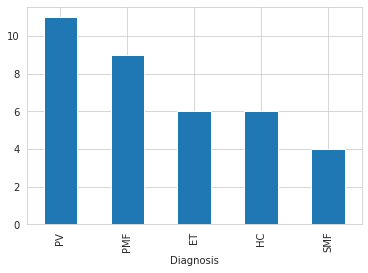

In [11]:
#Using pandas to plot things like diagnosis distribution
data.obs.value_counts('Diagnosis').plot(kind='bar')


In [12]:
#Viewing data matrix
data.obs

,index,Age [y],Sex,Diagnosis,Driver mutation,Allele burden [%],Source,Treatment,Karyotype,PCA_1,PCA_2
ET1_log2-GEX,ET1,41,F,ET,JAK2V617F,14,BM,Ruxolitinib,"46,XX",-1.831222,-26.796576
ET2_log2-GEX,ET2,53,F,ET,CALRins5,NaN,BM,untreated,"46,XX",-14.710409,-14.254035
ET4_log2-GEX,ET4,52,M,ET,CALRdel52,14,BM,peg Interferon,"46,XY",0.805866,-22.861004
ET7_log2-GEX,ET7,47,M,ET,MPLW515L,24,BM,Hydroxycarbamide,NaN,9.196147,-14.268322
ET8_log2-GEX,ET8,19,M,ET,triple-negative,0,BM,untreated,NaN,-9.789889,-24.862207
ET9_log2-GEX,ET9,33,F,ET,triple-negative,0,BM,peg Interferon,NaN,-9.089152,-21.407837
HC4_log2-GEX,HC4,29,F,HC,NaN,NaN,PB,untreated,"46,XX",-30.611607,2.287596
HC5_log2-GEX,HC5,27,F,HC,NaN,NaN,PB,untreated,"46,XX",-31.674107,2.807559
HC6_log2-GEX,HC6,28,M,HC,NaN,NaN,PB,untreated,"46,XY",-35.023483,-3.292778
HC7_log2-GEX,HC7,28,M,HC,NaN,NaN,PB,untreated,"46,XY",-43.012726,0.305229


In [65]:
data.obs.index[1][:-9]


'ET2'

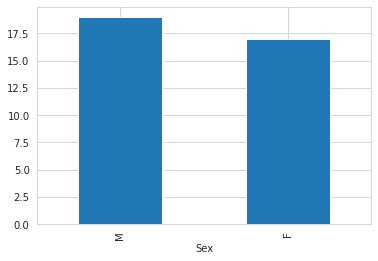

In [14]:
#Using pandas to plot different columns such as Sex, and Age
data.obs.value_counts("Sex").plot(kind="bar")

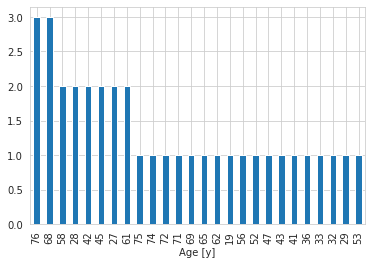

In [15]:
data.obs.value_counts("Age [y]").plot(kind="bar")

**1.3 Dimension Reduction**

I will perform linear dimension reduction using PCA (principle component analysis) to look at potential groups of samples in data.

PCA documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

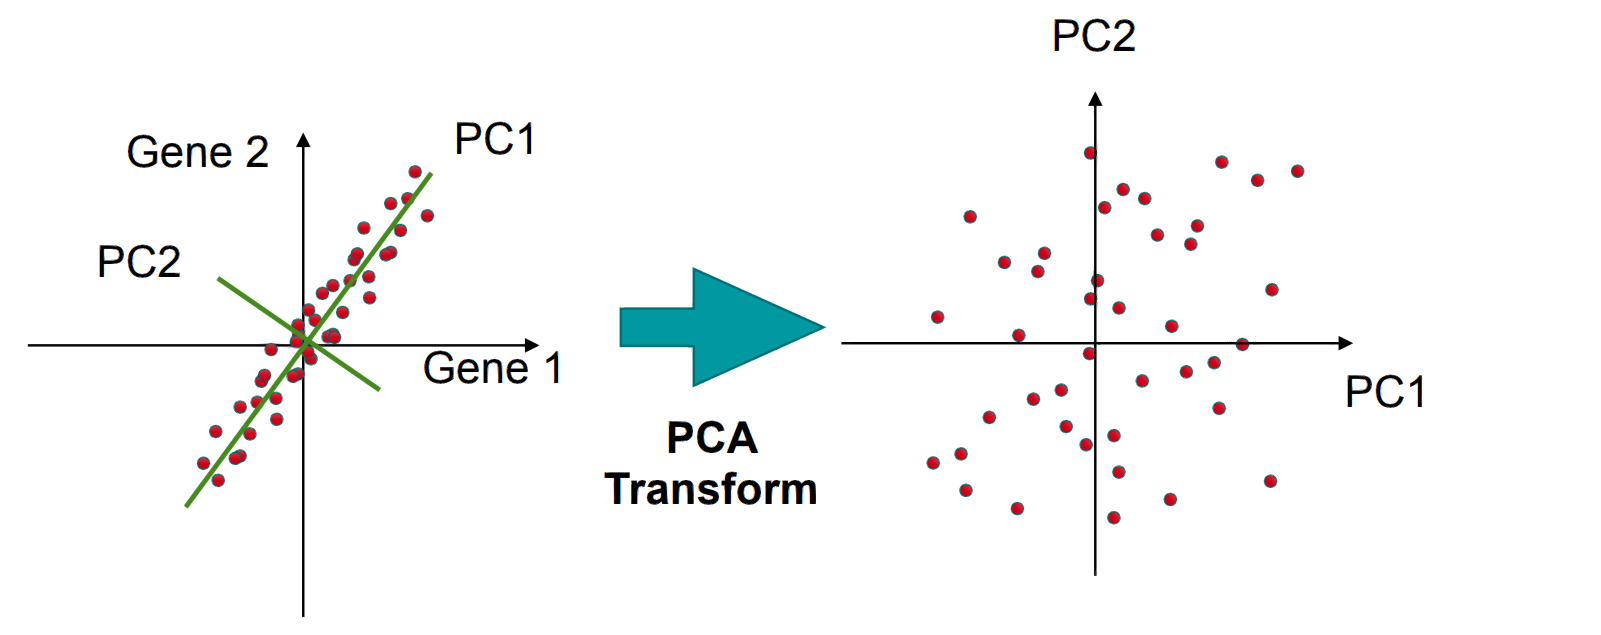

In [16]:
# Creating a PCA object using number of desired components as input

PCAcomp = PCA(n_components=3)

In [17]:
# Using gene expression matrix (data.X) to compute PCA

X_transformed = PCAcomp.fit_transform(data.X)

In [18]:
X_transformed       # an array with three values each for three PCA components

array([[ -1.8312258 , -26.79657   ,  -8.18236   ],
       [-14.710414  , -14.254048  ,  -2.774147  ],
       [  0.80586433, -22.861015  ,  -7.8975205 ],
       [  9.196153  , -14.268329  , -23.733751  ],
       [ -9.789899  , -24.862215  ,  11.694976  ],
       [ -9.089156  , -21.407856  ,   1.6774231 ],
       [-30.611616  ,   2.287601  , -25.936268  ],
       [-31.67412   ,   2.8075619 , -10.538336  ],
       [-35.02349   ,  -3.2927706 , -22.166798  ],
       [-43.012745  ,   0.3052281 ,  -2.827067  ],
       [-47.90195   ,   7.7161317 ,  -7.072821  ],
       [-30.385971  ,  31.192104  , -23.97392   ],
       [ 14.733362  ,  31.412216  ,   2.4988127 ],
       [ 31.092163  , -24.50263   , -23.49159   ],
       [ 17.82984   ,  10.521795  , -18.852573  ],
       [ 27.87481   ,   0.6035028 , -20.985786  ],
       [  0.9134159 , -22.454353  , -20.325201  ],
       [ 10.905968  ,  -2.2033038 ,  25.003096  ],
       [  5.3118973 ,  14.416451  ,  17.817263  ],
       [ 13.772731  ,  47.55876

**1.4 Plotting PCA results**

Plot results of PCA as scatter plots, using Seaborn here. 

Seaborn documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

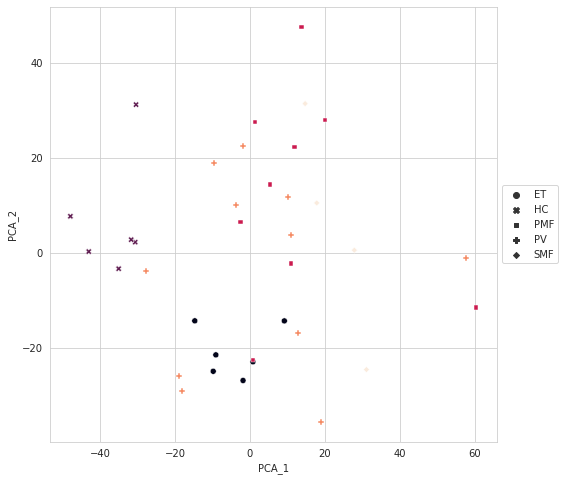

In [19]:
# Visualising PCA in scatter plots

label1 = 'PCA_1' #defining labels respective to PCs
label2 = 'PCA_2'
label3 = 'PCA_3'
# Storing PCs in the obs matrix
data.obs[label1] = X_transformed[:,0]
data.obs[label2] = X_transformed[:,1]
data.obs[label3] = X_transformed[:,2]
plt.figure(figsize=(8,8))
sns.scatterplot(x=label1, y=label2,
                c=data.obs['Diagnosis'].cat.codes,   # Getting the category codes instead of diagnosis labels
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**1.5 Adding text over samples**

Text can be added over the dots in the plot above

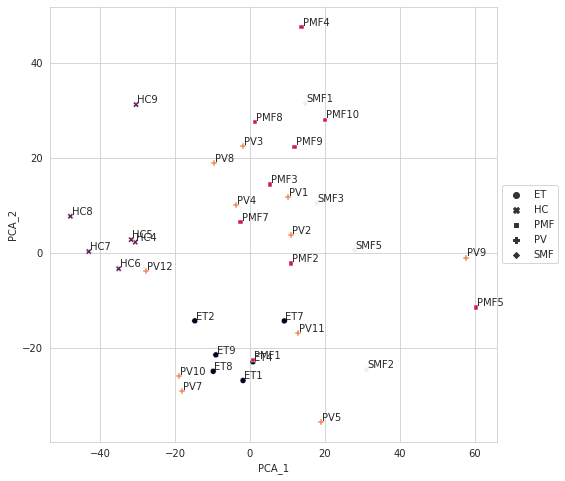

In [66]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=label1, y=label2,
                c=data.obs['Diagnosis'].cat.codes,   
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
# Will add a label showing sample name to each point from the PCA
for i in range(data.obs.shape[0]):
    plt.text(x=data.obs[label1][i]+0.3,
         y=data.obs[label2][i]+0.3,
         s=data.obs.index[i][:-9])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
data.obs.shape

(36, 12)

**1.6 Variance explained by each component**

In [22]:
PCAcomp.explained_variance_ratio_

array([0.19353671, 0.13592306, 0.09707926], dtype=float32)

Above results show that PC1 contributes 19.35% to the total variation, and PC2 and PC3 contribute 13.6% and 9.7% respectively.

**1.7 Gene importance per PC**

The output of PCAcomp.components_.T is of the shape [n_features, n_components]. n_features is the number of genes present in the data per sample, which is 25887, and n_components is number of PCs i.e. 3. 

If we look at first column, that's the genes for PC1, column two is PC2 and so on. The higher magnitude features (genes) in column 1 (PC1) are most important for first principal component PC1. 

In [23]:
#Taking transpose of PCAcomp.components_ gives output of shape [n_features, n_components] 
print(PCAcomp.components_.T.shape)
print(abs(PCAcomp.components_.T))  #abs gives the absolute values i.e magnitude for each feature

(25887, 3)
[[0.05629437 0.00959167 0.07299973]
 [0.08441176 0.08787405 0.09575754]
 [0.05296542 0.0673393  0.07278287]
 ...
 [0.06642094 0.04474526 0.0119365 ]
 [0.08178332 0.0498972  0.00066003]
 [0.05687026 0.06337668 0.01945012]]


1.8 Exercises:

1.8.1 Color the PCA using the clinical metadata Sex

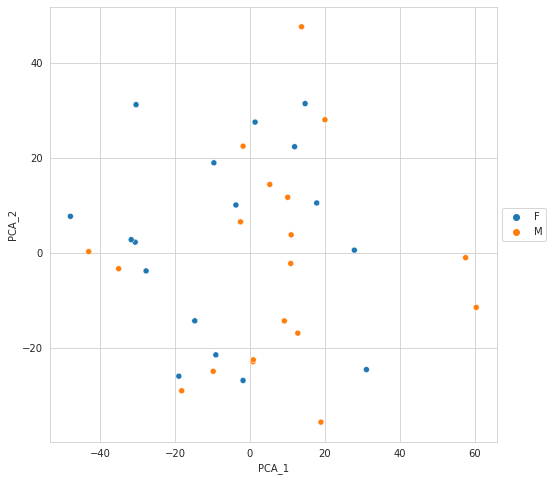

In [24]:
# Coloring PCA using metadata Sex
plt.figure(figsize=(8,8))
sns.scatterplot(x=label1, y=label2,
                hue = data.obs['Sex'],           # colors in the plot
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

1.8.2 Change the size of each dot using the Allele Burden clinical metadata

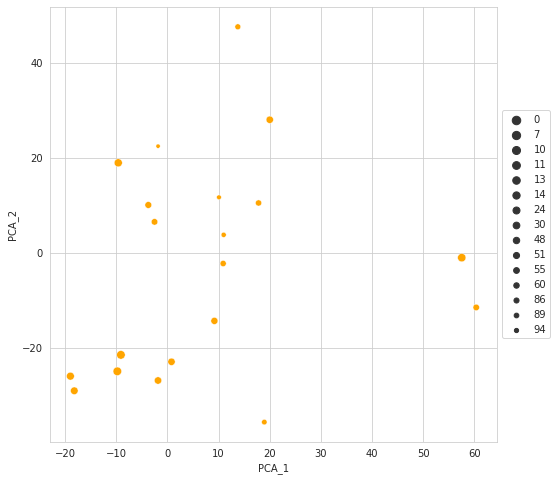

In [25]:
# changing dot size using Allele Burden metadata
plt.figure(figsize=(8,8))
sns.scatterplot(x=label1, y=label2,
                size=data.obs['Allele burden [%]'],     # different size dots in the plot, excludes NaN values 
                color='orange',
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

1.8.3 Check if driver mutations groups together in the PCA

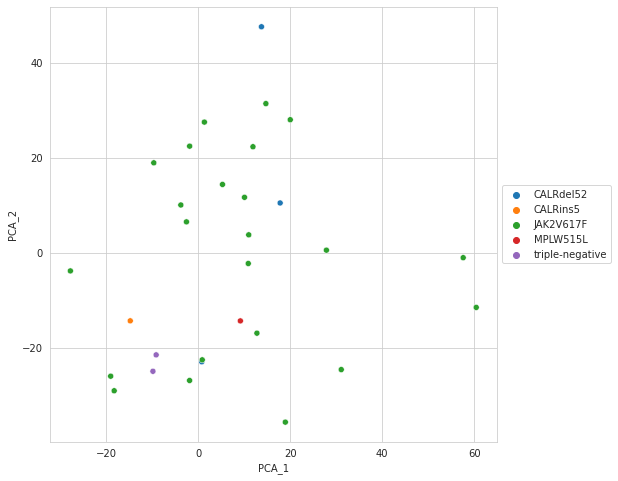

In [26]:
# Coloring PCA using Driver mutation metadata
plt.figure(figsize=(8,8))
sns.scatterplot(x=label1, y=label2,
                hue = data.obs['Driver mutation'],           # colors in the plot
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

1.8.4 Plot PC2 vs PC3

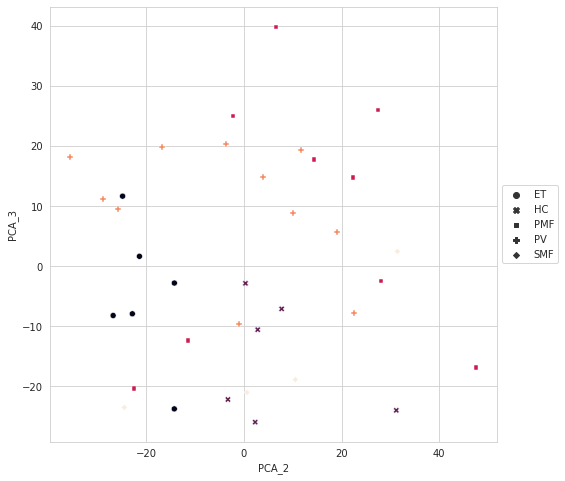

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=label2, y=label3,                  # Plotting PC2 vs PC3
                c=data.obs['Diagnosis'].cat.codes,   # Encoding categorical variable
                style=data.obs['Diagnosis'],
                data=data.obs,
                legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# 2. Differential Gene Expression: Healthy vs Diseased #

This section contains differential expression analysis. I will explore genes with change in expression in healthy and diseased (MPNs) first.

##2.1 Defining our comparisons

First, I need to define comparisons. I am creating a new variable, "condition" for this.

In [28]:
# Setting the condition to False if Diagnosis is HC (Healthy), otherwise set to True  
data.obs['condition'] = data.obs['Diagnosis']!='HC'
# Change bool to int
data.obs['condition'] = data.obs['condition'].astype('int') #(False is 0 which is the control group i.e. healthy)

In [29]:
data.obs

,index,Age [y],Sex,Diagnosis,Driver mutation,Allele burden [%],Source,Treatment,Karyotype,PCA_1,PCA_2,PCA_3,condition
ET1_log2-GEX,ET1,41,F,ET,JAK2V617F,14,BM,Ruxolitinib,"46,XX",-1.831226,-26.796570,-8.182360,1
ET2_log2-GEX,ET2,53,F,ET,CALRins5,NaN,BM,untreated,"46,XX",-14.710414,-14.254048,-2.774147,1
ET4_log2-GEX,ET4,52,M,ET,CALRdel52,14,BM,peg Interferon,"46,XY",0.805864,-22.861015,-7.897521,1
ET7_log2-GEX,ET7,47,M,ET,MPLW515L,24,BM,Hydroxycarbamide,NaN,9.196153,-14.268329,-23.733751,1
ET8_log2-GEX,ET8,19,M,ET,triple-negative,0,BM,untreated,NaN,-9.789899,-24.862215,11.694976,1
ET9_log2-GEX,ET9,33,F,ET,triple-negative,0,BM,peg Interferon,NaN,-9.089156,-21.407856,1.677423,1
HC4_log2-GEX,HC4,29,F,HC,NaN,NaN,PB,untreated,"46,XX",-30.611616,2.287601,-25.936268,0
HC5_log2-GEX,HC5,27,F,HC,NaN,NaN,PB,untreated,"46,XX",-31.674120,2.807562,-10.538336,0
HC6_log2-GEX,HC6,28,M,HC,NaN,NaN,PB,untreated,"46,XY",-35.023491,-3.292771,-22.166798,0
HC7_log2-GEX,HC7,28,M,HC,NaN,NaN,PB,untreated,"46,XY",-43.012745,0.305228,-2.827067,0


##2.2 Performing differential analysis with a t-test##

Below, I will perform a t-test to find genes with change in their expression when comparing the healthy and diseased groups

In [30]:
test = de.test.t_test(data=data,           #AnnData
                      grouping="condition" #.obs column used for analysis
                      )

2.2.1 Show the genes in a volacano plot

An initial check of results can be done by using a volcano plot. Volcano plot shows the change in expression (FC) in the x-axis vs the significance of this change (p-value) in the y-axis. Positive FC indicates genes that have higher expression in the disease samples rather than in the control samples. Negative FC indicates genes that have higher expression in the control samples, rather than in the disease samples, because log(FC) = log<E1> - log<E0>, where <E1> and <E0> are the arithmatic averages over the fuorescence-light intensity of samples in group 1 (i.e.  diseased group) and group 0 (i.e. control group), respectively. 

<Figure size 576x576 with 0 Axes>

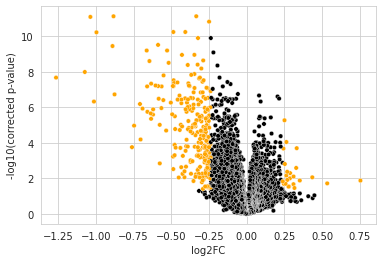

In [31]:
plt.figure(figsize=(8,8))
test.plot_volcano(corrected_pval=True, min_fc=1.18, alpha=0.05, size=20)
plt.show()

##2.3 Exploring the results##

To furthur this analysis, I will get test output table in a pandas dataframe with the results for the DE analysis, and will look for up or down-regulated genes in the disease

In [32]:
result = test.summary()  #Get test result in pandas df
result.head()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,AREG,0.000890,0.013281,0.753875,9.454930,False,False
1,DNTT,0.001531,0.019040,0.533574,10.555662,False,False
2,EBF1,0.033235,0.129498,0.437239,9.145275,False,False
3,MPO,0.000001,0.000090,0.262981,15.020545,False,False
4,P2RY14,0.000470,0.008660,0.434544,7.300814,False,False


In [33]:
result.tail()

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
25882,LGMN,5.136033e-09,1.176606e-06,-0.691226,9.505555,False,False
25883,VCAM1,1.691905e-09,4.716628e-07,-1.013646,7.595639,False,False
25884,CD163,9.371790e-16,8.086918e-12,-1.037461,7.781432,False,False
25885,FGL2,2.586023e-06,1.747895e-04,-0.761476,10.465884,False,False
25886,TIMD4,2.450861e-11,2.114848e-08,-1.265102,7.275786,False,False


Next, select the DE genes so that the corrected p-values and the change in expression satisfy some thresholds. Here, we want genes that appear to be significantly expressed (qvalue < 0.05), and with a high change in expression value (|log2fc| >0.5).

In [34]:
highlight = np.bitwise_and(result['qval'] <= 0.05,np.abs(result['log2fc']) > 0.5)

To see how those DE-genes are expressed in this dataset, we will make a heatmap using seaborn.

In [35]:
result_highlights = test.summary().loc[highlight,]

In [36]:
result_highlights = result_highlights.sort_values(by='log2fc', ascending=False)

Showing the most under and over-expressed genes in comparisons.

In [37]:
genes = [result_highlights['gene'].iloc[-1],result_highlights['gene'].iloc[1]]

In [38]:
intgenes=data[:,genes].to_df()
intgenes['Diagnosis'] = data.obs['Diagnosis']

In [39]:
intgenes.head()

Gene_Symbol,TIMD4,DNTT,Diagnosis
ET1_log2-GEX,11.862010,14.472263,ET
ET2_log2-GEX,7.270792,14.282142,ET
ET4_log2-GEX,10.900046,15.104199,ET
ET7_log2-GEX,12.741930,12.353701,ET
ET8_log2-GEX,8.951712,14.629143,ET


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else

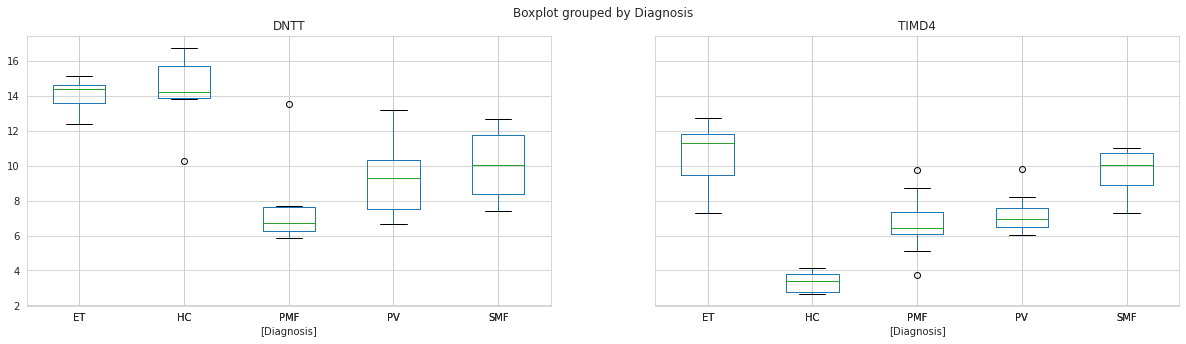

In [40]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)
intgenes.boxplot(by='Diagnosis', ax=ax)
plt.show()

Initially, using the euclidean distance with the average clustering method

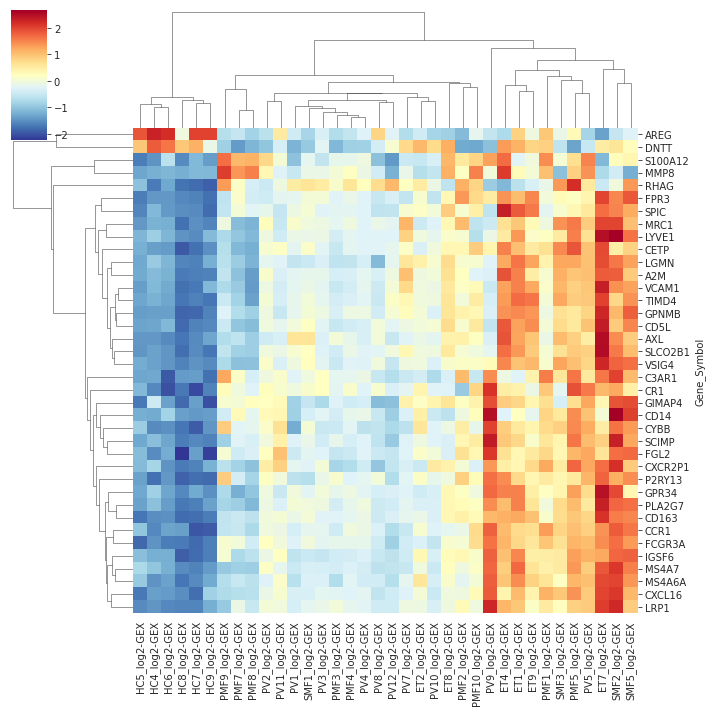

In [41]:
sns.clustermap(data[:, result_highlights['gene']].to_df().T,
               metric='euclidean',  #Distance
               method='average',    #Clustering method
               cmap=plt.cm.RdYlBu_r,#color pallete
               z_score=0            #Normalization axis, 0:rows, 1:columns
               )

#2.4 Gene Ontology enrichment analysis#

Now checking if DE up-regulated genes are associated with particular gene ontology terms using a Fischer's exact test, as implemented by g:profiler.

In [42]:
gp = GProfiler(return_dataframe=True)  # Creating a gprofiler object
up_regulated = result_highlights['gene'][result_highlights['log2fc']>0].tolist()
enrich = gp.profile(organism='hsapiens',
                    query=up_regulated,
                    sources=["GO:MF", "GO:CC", "GO:BP"])  # Querying g:profiler, providing up_regulated genes as input

#checking the results
enrich                

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0060598,dichotomous subdivision of terminal units invo...,0.049535,True,"""The process in which the terminal end of a ma...",1,2,1,21029,0.5,1.0,query_1,"[GO:0060600, GO:0060751]"
1,GO:MF,GO:0003912,DNA nucleotidylexotransferase activity,0.049588,True,"""Catalysis of the reaction: deoxynucleoside tr...",1,2,1,20166,0.5,1.0,query_1,"[GO:0016779, GO:0140097]"


Plotting the results as a bar plot. The significance is shown as a -log(10) of the p-value, where higher values indicate a higher significance.

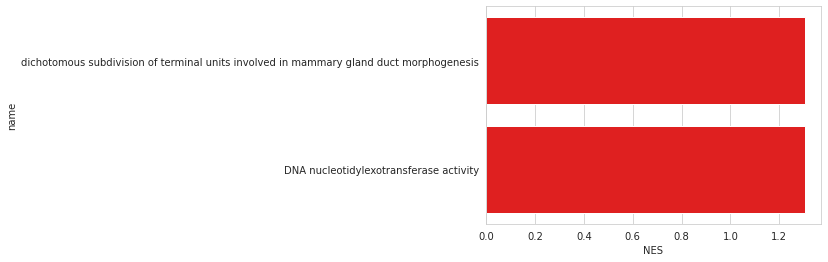

In [43]:
enrich['NES'] = -np.log10(enrich['p_value'])
enrich.sort_index(axis=0, level='NES', inplace=True)
sns.barplot(x='NES', y='name', data=enrich.iloc[0:20,],color='red')